In [10]:
# Generic libraries
import numpy as np
import pandas as pd
import scipy as sp
from tqdm import tqdm
import seaborn as sns

%matplotlib notebook
from ipywidgets import *
import matplotlib.pyplot as plt
plt.style.context('seaborn')
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as mtick
from collections import namedtuple
from tabulate import tabulate
from IPython.display import Latex
from IPython.display import HTML
from IPython.core.pylabtools import figsize
from matplotlib import rc
from scipy.spatial.distance import squareform
from itertools import product
import inspect
import multiprocessing
import time
import os
import glob
from pathlib import Path


In [11]:
# MDAnalysis
import MDAnalysis as mda
from MDAnalysis.coordinates.base import Timestep
from MDAnalysis.lib import distances
from MDAnalysis.analysis.base import analysis_class
from MDAnalysis.lib.distances import capped_distance, self_capped_distance
from MDAnalysis.lib.distances import distance_array, self_distance_array
from MDAnalysis.analysis import pca, contacts, align, diffusionmap, rms


In [12]:
nodna = True

if nodna:
    simdir = Path('../data/00-external_nodna/')
    PDB = simdir / '5Y36_nodna.pdb'
    GRO = simdir / '5Y36_nodna_box.gro'
    trajdir = '../data/04-prod_nodna/'
else:
    simdir = Path('../data/00-external/')
    PDB = simdir / '5Y36.pdb'
    GRO = simdir / '5Y36_box.gro'
    trajdir = '../data/04-prod/'


# set paths for output
plotpath = "../plots/"
datapath = "../data/analysis/"

if nodna:
    output_name = "prod_nodna_"
else:
    output_name = "prod_"

In [13]:
## import full trajectory data 
XTC  = trajdir + 'cas9_prod_pbc_all.xtc'

## universe creation
u = mda.Universe(str(GRO), str(XTC))
#u_new = u.copy() # used as a reference in memory for mapping calculations
#ref0 = mda.Universe(str(GRO))
print(u.select_atoms("not name W NA CL").n_atoms, 'system atoms')

# other info
box = u.dimensions
print('box dimensions:', box)
nframes = u.trajectory.n_frames
print(nframes, 'frames')
dt = u.trajectory.dt # ns per frame, equal to nstxout*0.002
dt_ns = dt / 1000
time = np.arange(0, dt*nframes, dt)
t_ns = time / 1000
print(t_ns[-1], 'ns')


25700 system atoms
box dimensions: [174.54497 174.54497 174.54497  60.       60.       90.     ]
7057 frames
352.8 ns


In [14]:
## we import the equilibrated trajectory, with the first tot ns (it's in the filename) cut out
if nodna:
    XTC_cut = trajdir + 'cas9_prod_pbc_240cut.xtc'
else:
    XTC_cut = trajdir + 'cas9_prod_pbc_205cut.xtc'
## universe creation
u_cut = mda.Universe(str(GRO), str(XTC_cut))
time_cut = np.arange(0, dt*u_cut.trajectory.n_frames, dt)
t_ns_cut = time_cut / 1000
print(t_ns_cut[-1], 'ns')


112.8 ns


### PCA of the whole trajectory

In [15]:
aligner = align.AlignTraj(u, u, select='backbone', in_memory=True).run()

In [16]:
# !! requires a lot of memory (~5GB) !!
# TODO check why it does not work for backbone
pc = pca.PCA(
    u, select='protein and name CA', align=False, mean=None, n_components=None, verbose=True).run()


Mean Calculation:   0%|          | 0/7057 [00:00<?, ?it/s]

  0%|          | 0/7057 [00:00<?, ?it/s]

In [17]:
print(pc.results.cumulated_variance[0])
print(pc.results.cumulated_variance[1])
print(pc.results.cumulated_variance[2])
print(pc.results.cumulated_variance[3])
print(pc.results.cumulated_variance[4])
print(pc.results.cumulated_variance[20])

0.23726300536044653
0.4308965744260742
0.5390087712491245
0.5911985700695271
0.6314930033176529
0.8420779138691362


<IPython.core.display.Javascript object>


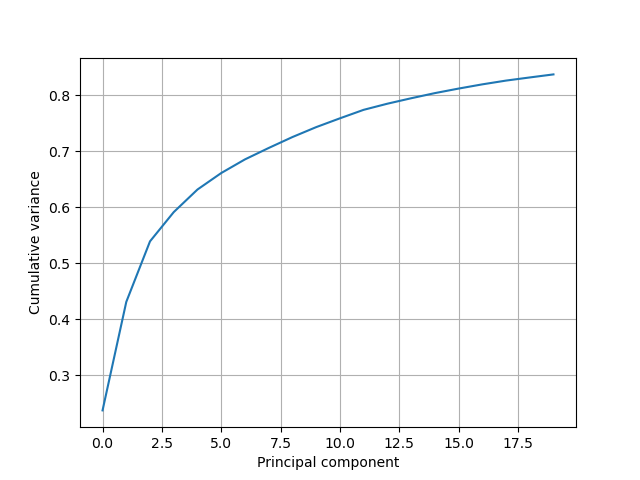

In [18]:
fig = plt.figure()
plt.plot(pc.results.cumulated_variance[:20])
plt.xlabel('Principal component')
plt.ylabel('Cumulative variance');
plt.grid()
plt.savefig(os.path.join(plotpath, output_name+'pca_cumvariance.pdf'))

In [19]:
backbone = u.select_atoms('protein and name CA')
ncomp = 20 # manually chosen in order to include 80% of the variance
transformed = pc.transform(backbone, n_components=ncomp)
print(transformed.shape)
df = pd.DataFrame(transformed, columns=['PC{}'.format(i+1) for i in range(ncomp)])
df.insert(loc=0, column='Time (ns)', value=t_ns)

(7057, 20)


In [20]:
# save ordered principal components for later use
df.to_pickle(datapath+output_name+"pca.pkl")
df.to_csv(datapath+output_name+"pca.csv", sep='\t', encoding='utf-8', index=False)

ImportError: cannot import name 'FilePath' from 'pandas._typing' (/home/kryohi/.miniconda3/envs/mdanal/lib/python3.9/site-packages/pandas/_typing.py)

In [11]:
df = pd.read_csv(datapath+'pca.csv', index_col=0, sep="\t")
df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
Time (ns),,,,,,,,,,,,,,,,,,,,
0.00,-20.732534,-28.255593,-27.986894,24.553608,51.724908,-60.544083,-8.208574,-28.709632,-3.116102,-31.112219,23.038343,2.653646,-15.309269,-18.353451,13.666961,-27.707095,-4.741053,8.456027,6.146620,-6.700058
0.05,-28.973456,-26.497015,-18.629113,27.107718,48.898124,-52.306368,-5.744500,-24.890206,7.173808,-33.592101,22.629300,-1.483675,-17.776876,-19.545282,19.683265,-28.040271,3.356826,8.306337,5.026643,2.827619
0.10,-33.328822,-33.045480,-20.144847,21.324273,46.205173,-69.852633,-8.667994,-18.562838,4.043731,-32.353396,26.123497,-0.713178,-11.793256,-15.009842,22.121648,-27.819101,4.845320,6.614251,1.514878,-2.215753
0.15,-37.932351,-30.100430,-8.407598,21.352365,53.866179,-63.084989,-13.788714,-20.151357,3.576818,-33.890000,23.121930,2.682801,-15.934269,-11.977383,19.522614,-28.939115,12.256813,6.810881,0.397814,-5.335791
0.20,-34.911406,-30.069841,-11.854481,20.635722,45.378338,-64.685501,-7.782525,-20.372568,-0.368541,-30.876664,20.092771,4.239319,-23.175839,-9.620302,12.292905,-29.129324,6.750559,7.571494,0.198659,-1.875446


In [12]:
# very slow, use Makie version instead

#%matplotlib notebook
#g = sns.PairGrid(df, hue='Time (ps)', palette=sns.color_palette('Oranges_d', n_colors=len(df)));

In [13]:
#_ = g.map(plt.scatter, marker='.');
#g.savefig(plotpath+"pairplot_pca.pdf")


## Autocorrelation

In [14]:
## autocorrelation estimate for box-averaging
def autocorrelation(x):
    n = len(x)
    variance = x.var()
    x = x-x.mean()
    #r = np.array([(x[:n-k]*x[-(n-k):]).sum() for k in range(n)]) #slow method using the definition
    r = np.correlate(x, x, mode = 'full')[-n:] # fast method, same result!
    result = r/(variance*(np.arange(n, 0, -1)))
    return result

In [15]:
nlog = len(df)
t_acf = df.index[1:nlog//2]
print(nlog)
    
acf1 = autocorrelation(df['PC1'])
acf2 = autocorrelation(df['PC2'])
acf3 = autocorrelation(df['PC3'])
acf4 = autocorrelation(df['PC4'])
acf5 = autocorrelation(df['PC5'])


11501


<IPython.core.display.Javascript object>


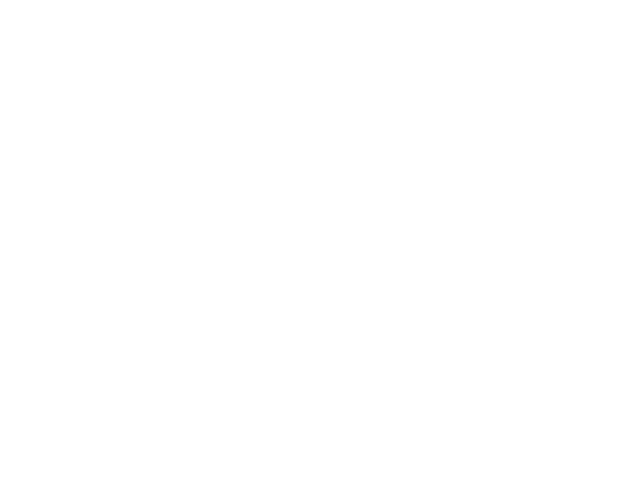

In [16]:
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(t_acf, acf1[1:nlog//2], label=r"PCA1")
ax.plot(t_acf, acf2[1:nlog//2], label=r"PCA2")
ax.plot(t_acf, acf3[1:nlog//2], label=r"PCA3")
ax.plot(t_acf, acf4[1:nlog//2], label=r"PCA4")
ax.plot(t_acf, acf5[1:nlog//2], label=r"PCA5")
plt.xlabel("time lag [ns]")
plt.ylabel("acf")
plt.grid()
plt.legend()
plt.savefig(os.path.join(plotpath, output_name+'pca_acf.pdf'))

## Equilibration tests

### PCA from 205ns
Now we recalculate the pca with a limited trajectory (start_frame = 3120)

In [17]:

## import full trajectory data 
trajdir = '../data/04-prod/'
#XTC_cut = trajdir + 'cas9_prod_pbc_cut.xtc'
XTC_cut = trajdir + 'cas9_prod_pbc_205cut.xtc'

## universe creation
u_cut = mda.Universe(str(GRO), str(XTC_cut))
#u_new = u.copy() # used as a reference in memory for mapping calculations
#ref0 = mda.Universe(str(GRO))
print(u_cut.select_atoms("protein or name MG").n_atoms, 'protein atoms')

# other info
box = u_cut.dimensions
print('box dimensions:', box)
nframes = u_cut.trajectory.n_frames
print(nframes, 'frames')
dt = u_cut.trajectory.dt # ns per frame, equal to nstxout*0.002
time = np.arange(0, dt*nframes, dt)
t_ns = time / 1000
print(t_ns[-1], 'ns')


22526 protein atoms
box dimensions: [183.03412  183.03412  183.03404   60.000008  60.000008  90.      ]
7401 frames
370.0 ns


In [18]:
aligner = align.AlignTraj(u_cut, u_cut, select='protein and name CA', in_memory=True).run()

In [19]:
pca_eq = pca.PCA(
    u_cut, select='protein and name CA', align=False, mean=None, n_components=None, verbose=True).run()
#u.trajectory[block * size:(block + 1) * size]

Mean Calculation:   0%|          | 0/7401 [00:00<?, ?it/s]

  0%|          | 0/7401 [00:00<?, ?it/s]

In [20]:
len(pca_eq.results.p_components)

4104

In [21]:
print(pca_eq.results.cumulated_variance[0])
print(pca_eq.results.cumulated_variance[1])
print(pca_eq.results.cumulated_variance[2])
print(pca_eq.results.cumulated_variance[3])
print(pca_eq.results.cumulated_variance[4])
print(pca_eq.results.cumulated_variance[20])
print(pca_eq.results.cumulated_variance[21])

# at equilibrium the variance should be more evenly distributed among the components

0.2770953048160339
0.39138821795788076
0.4587475393125744
0.5050515490169012
0.5437420234772028
0.7658952008958616
0.7709327464743578


<IPython.core.display.Javascript object>


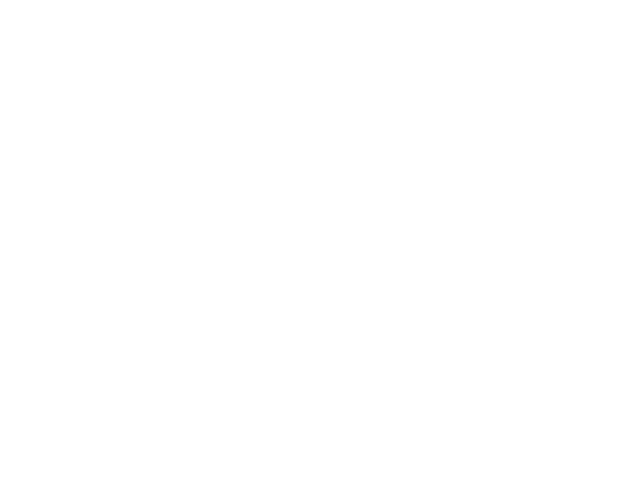

In [22]:
fig = plt.figure()
plt.plot(pca_eq.results.cumulated_variance[:70])
plt.xlabel('Principal components')
plt.ylabel('Cumulative variance')
plt.grid()
plt.savefig(os.path.join(plotpath, output_name+'pca_cumvariance_cut.pdf'))

In [23]:
protein_ca = u_cut.select_atoms('protein and name CA')
ncomp = 20 # manually chosen in order to include 70-80% of the variance
transformed = pca_eq.transform(protein_ca, n_components=ncomp, start=1, stop=nframes)
print(transformed.shape)
df_eq = pd.DataFrame(transformed, columns=['PC{}'.format(i+1) for i in range(ncomp)])
t_ns_eq = t_ns[0:-1:1]
print(t_ns_eq)
df_eq.insert(loc=0, column='Time (ns)', value=t_ns_eq)
df_eq.head()

(7400, 20)
[0.0000e+00 5.0000e-02 1.0000e-01 ... 3.6985e+02 3.6990e+02 3.6995e+02]


,Time (ns),PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
0,0.00,47.973925,-16.484750,38.690981,0.668896,0.557574,-12.863192,-36.069243,0.949228,4.165311,...,-11.899202,-3.429172,-4.893618,-4.781663,8.515640,-7.083478,1.266622,-2.600200,4.548292,0.899986
1,0.05,54.885014,-14.168801,38.535795,-0.967882,-0.222766,-12.449825,-39.268153,6.831248,0.065837,...,-8.193013,-4.498412,-4.542493,-4.276463,8.712200,-5.361188,-1.487372,-6.032365,2.362207,-4.537023
2,0.10,54.015261,-15.099289,36.974045,-0.242993,-2.318212,-4.343120,-38.912603,9.777646,-3.189717,...,-10.470091,0.051596,-10.462534,-9.426371,9.041973,-7.018886,-2.917019,-0.435348,-0.355243,-1.299420
3,0.15,50.732509,-8.935808,38.284887,3.140879,-10.596982,-7.301921,-41.226254,6.537632,-8.858110,...,-7.880860,1.584990,-4.749082,-5.047670,10.693386,-3.333746,1.442510,-2.699536,8.809118,1.473431
4,0.20,56.657112,-17.980561,37.631259,-4.488528,-8.605262,-3.755269,-39.612432,5.159651,-4.175450,...,-5.467001,-4.749774,-4.425760,-0.900859,12.663136,-0.808347,1.376450,0.647562,1.948744,-0.259436


In [ ]:
# project the first pc onto the atomic coordinates of the cas
pc1 = pca_eq.p_components[:, 0]
print(len(pc1))
trans1 = transformed[:, 0]
print(len(trans1))
projected = np.outer(trans1, pc1) + pca_eq.mean
coordinates = projected.reshape(len(trans1), -1, 3)
proj1 = mda.Merge(backbone)
proj1.load_new(coordinates, order="fac")

In [24]:
# save ordered principal components for later use
df_eq.to_pickle(datapath+"pca_cut.pkl")
df_eq.to_csv(datapath+"pca_cut.csv", sep='\t', encoding='utf-8', index=False)

In [25]:
df_eq = pd.read_csv(datapath+'pca_cut.csv', index_col=0, sep="\t")
df_eq.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
Time (ns),,,,,,,,,,,,,,,,,,,,
0.00,47.973925,-16.484750,38.690981,0.668896,0.557574,-12.863192,-36.069243,0.949228,4.165311,-2.576399,-11.899202,-3.429172,-4.893618,-4.781663,8.515640,-7.083478,1.266622,-2.600200,4.548292,0.899986
0.05,54.885014,-14.168801,38.535795,-0.967882,-0.222766,-12.449825,-39.268153,6.831248,0.065837,0.454000,-8.193013,-4.498412,-4.542493,-4.276463,8.712200,-5.361188,-1.487372,-6.032365,2.362207,-4.537023
0.10,54.015261,-15.099289,36.974045,-0.242993,-2.318212,-4.343120,-38.912603,9.777646,-3.189717,0.990288,-10.470091,0.051596,-10.462534,-9.426371,9.041973,-7.018886,-2.917019,-0.435348,-0.355243,-1.299420
0.15,50.732509,-8.935808,38.284887,3.140879,-10.596982,-7.301921,-41.226254,6.537632,-8.858110,3.234775,-7.880860,1.584990,-4.749082,-5.047670,10.693386,-3.333746,1.442510,-2.699536,8.809118,1.473431
0.20,56.657112,-17.980561,37.631259,-4.488528,-8.605262,-3.755269,-39.612432,5.159651,-4.175450,2.840070,-5.467001,-4.749774,-4.425760,-0.900859,12.663136,-0.808347,1.376450,0.647562,1.948744,-0.259436


<IPython.core.display.Javascript object>


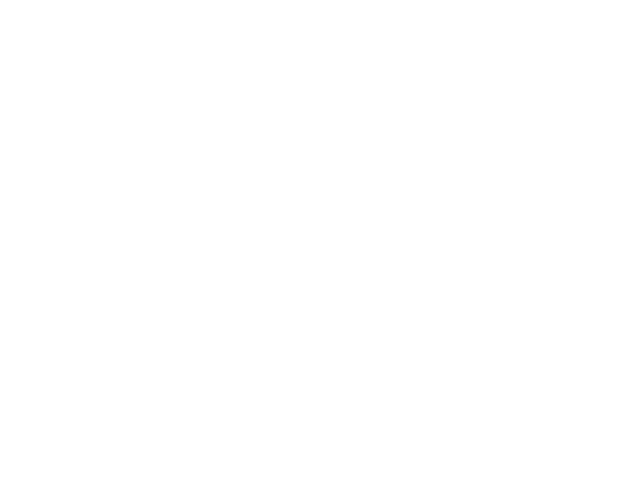

In [26]:
pc_eq = df_eq

from scipy.ndimage.filters import uniform_filter1d

fig = plt.figure()
ax = plt.subplot(111)
ax.plot(t_ns[0:-1], uniform_filter1d(pc_eq['PC1'], size=100), label=r"PCA1", lw=0.8)
ax.plot(t_ns[0:-1], uniform_filter1d(pc_eq['PC2'], size=100), label=r"PCA2", lw=0.8)
ax.plot(t_ns[0:-1], uniform_filter1d(pc_eq['PC3'], size=100), label=r"PCA3", lw=0.8)
ax.plot(t_ns[0:-1], uniform_filter1d(pc_eq['PC4'], size=100), label=r"PCA4", lw=0.8)
ax.plot(t_ns[0:-1], uniform_filter1d(pc_eq['PC5'], size=100), label=r"PCA5", lw=0.8)
#ax.plot(t_acf, acf6[1:nlog//2], label=r"PCA6")
plt.xlabel("t [ns]")
plt.ylabel("PC")
plt.grid()
plt.legend()
plt.savefig(os.path.join(plotpath, output_name+'pca_time_cut.pdf'))

In [27]:
nlog = len(pc_eq)
t_acf = pc_eq.index[1:nlog//2]# - min(pc_eq.index)
print(t_acf[-1])
    
acf1 = autocorrelation(pc_eq['PC1'])
acf2 = autocorrelation(pc_eq['PC2'])
acf3 = autocorrelation(pc_eq['PC3'])
acf4 = autocorrelation(pc_eq['PC4'])
acf5 = autocorrelation(pc_eq['PC5'])
acf6 = autocorrelation(pc_eq['PC6'])


184.95


<IPython.core.display.Javascript object>


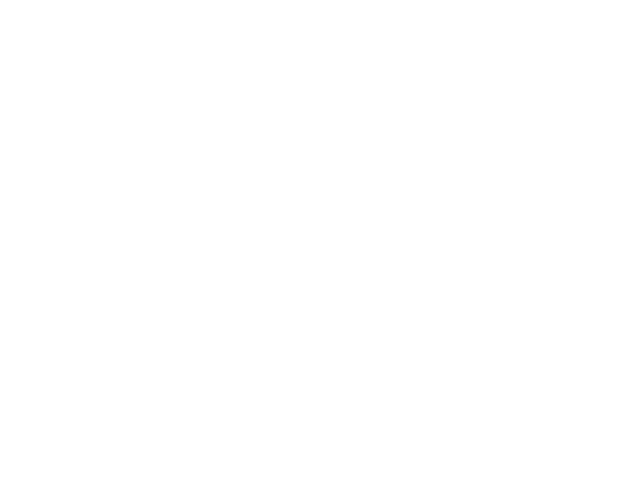

In [28]:
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(t_acf, acf1[1:nlog//2], label=r"PCA1")
ax.plot(t_acf, acf2[1:nlog//2], label=r"PCA2")
ax.plot(t_acf, acf3[1:nlog//2], label=r"PCA3")
ax.plot(t_acf, acf4[1:nlog//2], label=r"PCA4")
ax.plot(t_acf, acf5[1:nlog//2], label=r"PCA5")
#ax.plot(t_acf, acf6[1:nlog//2], label=r"PCA6")
plt.xlabel("time lag [ns]")
plt.ylabel("acf")
plt.grid()
plt.legend()
plt.savefig(os.path.join(plotpath, output_name+'pca_acf_cut.pdf'))

/home/kryohi/.miniconda3/envs/mdanal/lib/python3.9/site-packages/MDAnalysis/analysis/pca.py:329: DeprecationWarning: The `p_components` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.p_components` instead.
  warnings.warn(wmsg, DeprecationWarning)


4104
7400


ValueError: operands could not be broadcast together with shapes (7400,4104) (1368,3) 

## Other stuff